In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import tensorflow as tf
from tensorflow.keras import layers, models
import time
no = "2"
dataPath = "/content/drive/MyDrive/Colab Notebooks/project2/data/nifti"
# example_filename = os.path.join(data_path, 'example4d.nii.gz')
img1 = nib.load('{}/{}/image.nii.gz'.format(dataPath, no))
img2 = nib.load('{}/{}/mask.nii.gz'.format(dataPath, no))
xn = img1.shape[0]
yn = img1.shape[1]
zn = img1.shape[2]
imgs = { }
def readFile(no):
    global imgs, dataPath
    # example_filename = os.path.join(data_path, 'example4d.nii.gz')
    img1 = nib.load('{}/{}/image.nii.gz'.format(dataPath, no))
    img2 = nib.load('{}/{}/mask.nii.gz'.format(dataPath, no))
    xn = img1.shape[0]
    yn = img1.shape[1]
    zn = img1.shape[2]
    dImg = img1.get_data()
    dMask = img2.get_data()
    
    f = open('{}/{}/ranges.txt'.format(dataPath, no), "r")
    lines = f.readlines()
    valRange = [float(i) for i in (lines[0].split("(")[1].split(")")[0].split(" to "))]
    bounds = lines[1].split("; ")
    xs = [int(i) for i in bounds[0].split(": ")[1].split(")")[0].split(", ")]
    ys = [int(i) for i in bounds[1].split(": ")[1].split(")")[0].split(", ")]
    zs = [int(i) for i in bounds[2].split(": ")[1].split(")")[0].split(", ")]
    return { 'xn': xn, 'yn': yn, 'zn': zn, 'dImg': dImg, 'dMask': dMask, 'x0': xs[0], 'x1': xs[1], 'y0': ys[0], 'y1': ys[1], 'b': zs[0], 't': zs[1], 'z0': zs[0], 'z1': zs[1], 'width': xs[1] - xs[0], 'height': ys[1] - ys[0], 'depth': zs[1] - zs[0], "val0": valRange[0], "val1": valRange[1] }

In [3]:
def readImgBound(no):
    global dataPath
    f = open('{}/{}/ranges.txt'.format(dataPath, no), "r")
    lines = f.readlines()
    valRange = [float(i) for i in (lines[0].split("(")[1].split(")")[0].split(" to "))]
    bounds = lines[1].split("; ")
    xs = [int(i) for i in bounds[0].split(": ")[1].split(")")[0].split(", ")]
    ys = [int(i) for i in bounds[1].split(": ")[1].split(")")[0].split(", ")]
    zs = [int(i) for i in bounds[2].split(": ")[1].split(")")[0].split(", ")]
    return { 'x0': xs[0], 'x1': xs[1], 'y0': ys[0], 'y1': ys[1], 'b': zs[0], 't': zs[1], 'z0': zs[0], 'z1': zs[1], 'width': xs[1] - xs[0], 'height': ys[1] - ys[0], 'depth': zs[1] - zs[0], "val0": valRange[0], "val1": valRange[1] }

In [4]:
allBounds = { }
def readBoundAndShow():
    global allBounds
    print("w, h, d")
    w = 0
    h = 0
    d = 0
    for i in range(1, 101):
        bound = readImgBound(i)
        print("{}, {}, {}".format(bound["width"], bound["height"], bound["depth"]))
        if w < bound["width"]:
            w = bound["width"]
        if h < bound["height"]:
            h = bound["height"]
        if d < bound["depth"]:
            d = bound["depth"]
    print("max: {}, {}, {}".format(w, h, d))
    allBounds["w"] = w
    allBounds["h"] = h
    allBounds["d"] = d
readBoundAndShow()

w, h, d
93, 125, 18
106, 122, 35
100, 124, 34
108, 116, 44
119, 147, 44
85, 124, 41
110, 138, 35
98, 100, 47
102, 151, 44
119, 167, 43
90, 135, 42
124, 152, 41
111, 129, 40
87, 147, 41
103, 138, 50
86, 114, 37
89, 139, 40
72, 117, 35
112, 169, 43
98, 118, 30
95, 120, 34
150, 157, 35
99, 141, 37
138, 162, 60
67, 102, 45
92, 133, 32
124, 140, 39
107, 129, 43
75, 125, 43
93, 130, 34
96, 129, 38
115, 113, 32
98, 143, 30
113, 169, 25
113, 120, 46
94, 110, 35
94, 120, 34
95, 111, 38
112, 140, 39
77, 89, 28
90, 120, 38
116, 158, 41
86, 121, 31
121, 125, 42
138, 123, 38
74, 113, 55
70, 133, 23
115, 127, 32
93, 125, 39
89, 118, 35
94, 140, 38
74, 106, 33
106, 147, 33
91, 120, 55
88, 113, 20
67, 118, 45
96, 115, 38
90, 118, 41
100, 129, 34
102, 119, 24
102, 143, 25
75, 104, 49
99, 120, 34
75, 110, 40
82, 109, 47
109, 134, 54
74, 106, 33
67, 95, 50
122, 167, 31
96, 111, 44
67, 103, 49
102, 138, 51
100, 143, 44
94, 158, 195
120, 135, 32
132, 168, 37
112, 124, 27
122, 133, 38
74, 105, 33
100, 146, 

In [5]:
allBounds = {'w': 128, 'h': 128, 'd': 195}

In [6]:
def getImg(z, y0 = 0, y1 = yn, x0 = 0, x1 = xn, dataConstant = True, vLow = 120, vHigh = 2000, ds = [ ], minValue = -2000, maxValue = 0):
    data = [ ]
    for y in range(y0, y1):
        dy = [ ]
        for x in range(x0, x1):
            if ds[x][y][z] > vLow and ds[x][y][z] < vHigh:
                if dataConstant:
                    dy.append(maxValue)
                else:
                    dy.append(ds[x][y][z])
            else:
                dy.append(minValue)
        data.append(dy)
    # print(maxValue)
    return data
def getImgBound(imgNo = 2, z = 0, dataConstant = True, vLow = 120, vHigh = 2000, ds = 'dImg', minValue = -2000, maxValue = 0):
    global imgs, allBounds
    if str(imgNo) not in imgs:
        imgs = { }
        imgs[str(imgNo)] = readFile(imgNo)
    imgBound = imgs[str(imgNo)]
    x0 = imgBound["x0"]
    x1 = imgBound["x1"]
    y0 = imgBound["y0"]
    y1 = imgBound["y1"]
    # if imgBound["width"] < allBounds["w"]:
    x0 = x0 - int((allBounds["w"] - imgBound["width"]) / 2)
    x1 = x0 + allBounds["w"]
    # if imgBound["height"] < allBounds["h"]:
    y0 = y0 - int((allBounds["h"] - imgBound["height"]) / 2)
    y1 = y0 + allBounds["h"]
    # print("x0: {}, x1: {}, y0: {}, y1: {}".format(x0, x1, y0, y1))
    return getImg(imgBound["b"] + z, y0, y1, x0, x1, dataConstant, vLow, vHigh, imgBound[ds], minValue, maxValue)
def getModelImgs(no, z, model):
    imgs = [ ]
    imgs.append(getImgBound(no, z, False, -2000, 2000, 'dImg'))
    imgs = np.array(imgs)
    imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], imgs.shape[2], 1))
    overlapC = model2.predict(imgs)[0]
    
    imgD = getImgBound(no, z, False, -250, 250, 'dImg', -500, 500)
    for i in range(len(imgD)):
        for j in range(len(imgD[i])):
            if imgD[i][j] >= -250 and imgD[i][j] <= 250 and overlapC[int((imgD[i][j] + 250) / 5)] == 1:
                imgD[i][j] = 400
            elif imgD[i][j] >= -250 and imgD[i][j] <= 250:
                imgD[i][j] = -400
            elif imgD[i][j] < -250:
                imgD[i][j] = -400
            elif imgD[i][j] > 250:
                imgD[i][j] = 400
    # overlapC = [(0 if maskC * percent / 100 <= i else 1, maskC, i) for i in overlapC]
    # overlapC = [(0 if maskC * percent / 100 <= i else 1) for i in overlapC]
    return imgD
def getAllImgs(noFrom, noTo):
    global dataPath
    imgs = [ ]
    for no in range(noFrom, noTo):
        for z in range(0, readImgBound(no)["depth"]):
            imgs.append(getImgBound(no, z, False, -2000, 2000, 'dImg'))
        print(no)
    imgs = np.array(imgs)
    # print(imgs.shape)
    imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], imgs.shape[2], 1))
    np.save("{}/0_range/{}-{}-2_128".format(dataPath, noFrom, noTo), imgs)
    return imgs
def getAllYVals(noFrom, noTo):
    imgs = [ ]
    for no in range(noFrom, noTo):
        for z in range(0, readImgBound(no)["depth"]):
            imgs.append(getImgBound(no, z, True, 1, 4, 'dMask', 0, 1))
        print(no)
    imgs = np.array(imgs)
    # print(imgs.shape)
    imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], imgs.shape[2], 1))
    np.save("{}/0_range/{}-{}-2-y_128".format(dataPath, noFrom, noTo), imgs)
    return imgs

In [7]:
imgD = getAllImgs(80, 100)
imgD.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


(680, 128, 128, 1)

In [8]:
imgY = getAllYVals(80, 100)
imgY.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


(680, 128, 128, 1)

In [ ]:
np.save("{}/0_range/{}-{}-2_128".format(dataPath, 40, 80), imgD)
np.save("{}/0_range/{}-{}-2-y_128".format(dataPath, 40, 80), imgY)

In [ ]:
imgY[1][]

In [ ]:
tA = imgY[1].reshape((128 * 128))
tB = [ ]
for i in tA:
    if i not in tB:
        tB.append(i)
tB

[0, 1]

In [ ]:
def createModel():
    # state
    lastInit = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    # input layer
    inputLayer = layers.Input(shape=([allBounds["h"], allBounds["w"], 1]))
    # hidden layer
    hiddenLayer = layers.Conv2D(32, (3, 3), activation="relu")(inputLayer)
    hiddenLayer = layers.MaxPooling2D((2, 2))(hiddenLayer)
    hiddenLayer = layers.Conv2D(64, (3, 3), activation="relu")(hiddenLayer)
    hiddenLayer = layers.MaxPooling2D((2, 2))(hiddenLayer)
    hiddenLayer = layers.Conv2D(64, (3, 3), activation="relu")(hiddenLayer)
    hiddenLayer = layers.Flatten()(hiddenLayer)
    hiddenLayer = layers.Dense(200, activation="relu")(hiddenLayer)
    # output layer
    outputLayer = layers.Dense(100, activation="sigmoid", kernel_initializer=lastInit)(hiddenLayer)
    outputLayer = outputLayer * 1
    model = tf.keras.Model(inputLayer, outputLayer)
    return model

In [ ]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

In [ ]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

In [ ]:
def build_unet_model(inX, inY):
    # inputs
    inputs = layers.Input(shape=(inX, inY, 1))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(2, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [ ]:
unet_model = build_unet_model(128, 128)
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [ ]:
NUM_EPOCHS = 20
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

In [ ]:
res = unet_model.fit(imgD, imgY, epochs=10)

Epoch 1/10
53/53 [==============================] - 28s 526ms/step - loss: 0.1278 - accuracy: 0.9588
Epoch 2/10
53/53 [==============================] - 24s 460ms/step - loss: 0.1136 - accuracy: 0.9618
Epoch 3/10
53/53 [==============================] - 25s 466ms/step - loss: 0.1001 - accuracy: 0.9647
Epoch 4/10
53/53 [==============================] - 24s 459ms/step - loss: 0.0982 - accuracy: 0.9659
Epoch 5/10
53/53 [==============================] - 24s 458ms/step - loss: 0.0873 - accuracy: 0.9688
Epoch 6/10
53/53 [==============================] - 24s 462ms/step - loss: 0.0812 - accuracy: 0.9704
Epoch 7/10
53/53 [==============================] - 24s 461ms/step - loss: 0.0752 - accuracy: 0.9720
Epoch 8/10
53/53 [==============================] - 24s 460ms/step - loss: 0.0715 - accuracy: 0.9736
Epoch 9/10
53/53 [==============================] - 24s 462ms/step - loss: 0.0701 - accuracy: 0.9741
Epoch 10/10
53/53 [==============================] - 24s 462ms/step - loss: 0.0647 - accura

In [ ]:
unet_model.save("{}/0_range/model_{}-2_128".format(dataPath, 80))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/project2/data/nifti/0_range/model_80-2_128/assets


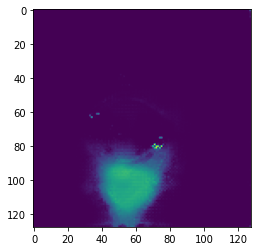

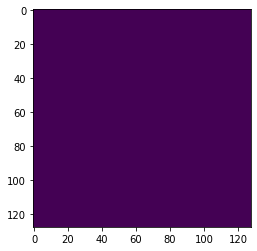

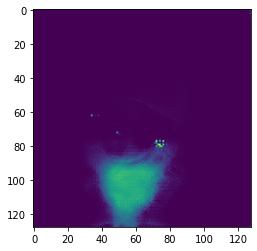

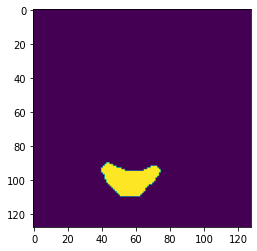

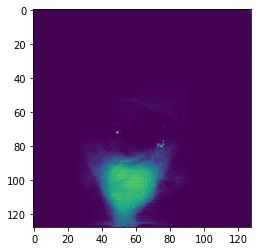

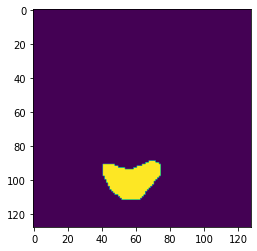

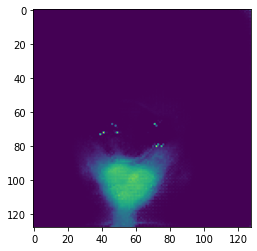

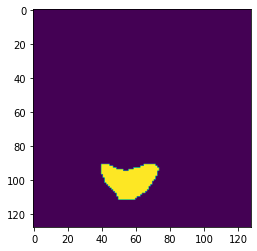

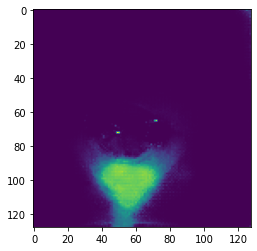

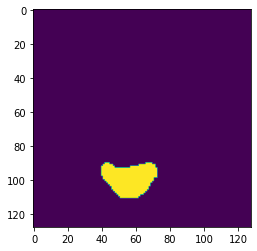

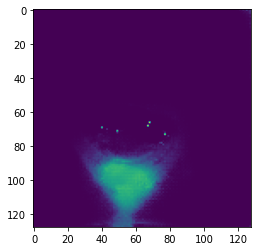

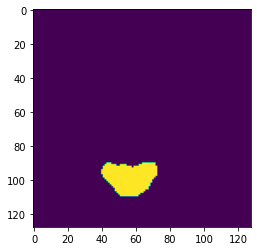

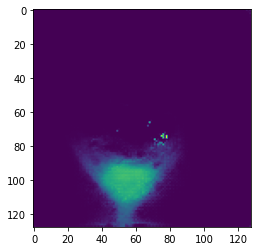

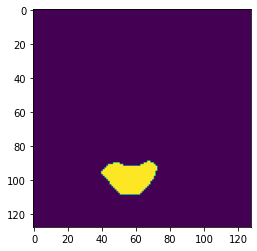

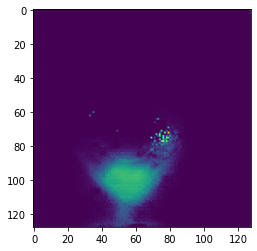

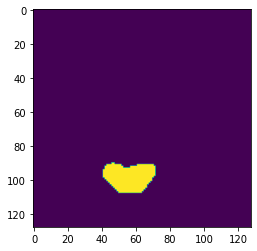

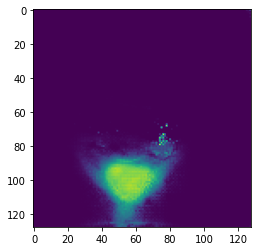

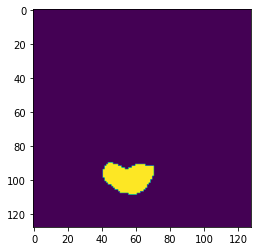

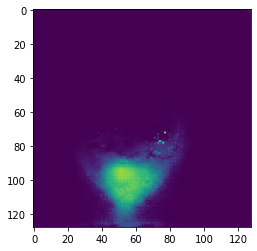

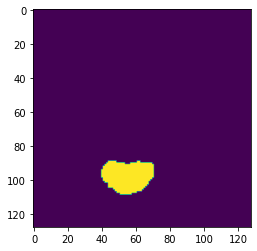

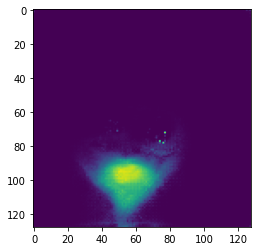

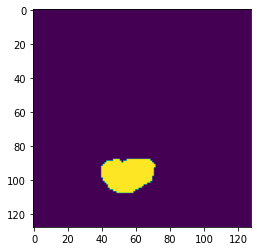

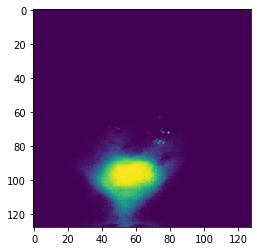

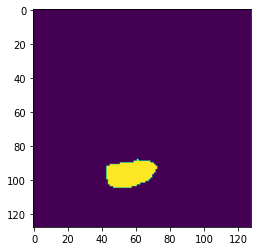

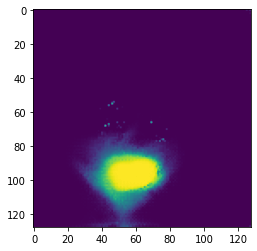

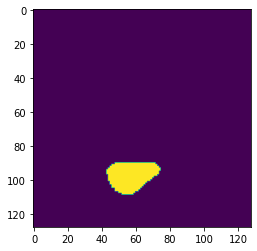

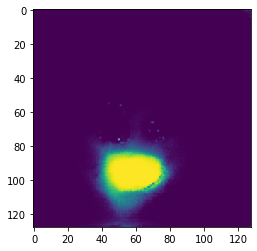

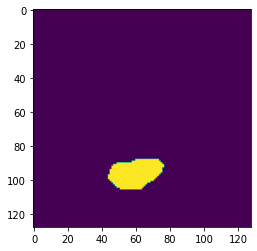

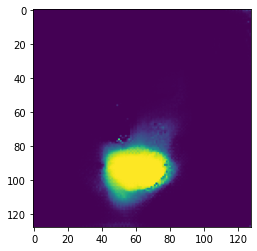

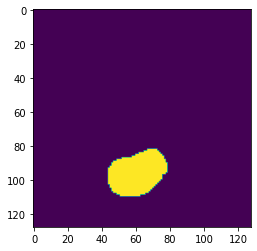

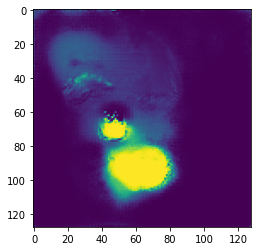

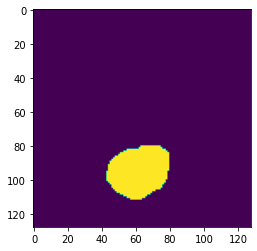

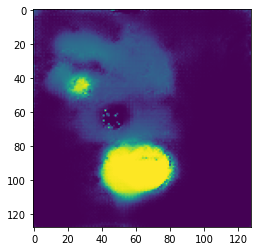

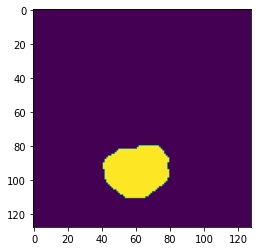

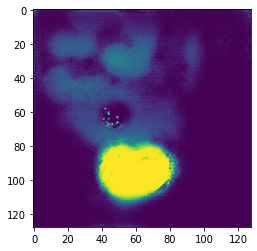

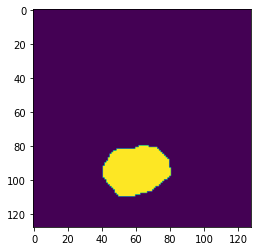

In [ ]:
def testModel(no, z):
    imgTest = [ ]
    imgTest.append(getImgBound(no, z, False, -2000, 2000, 'dImg'))
    imgTest = np.array(imgTest)
    imgTest = imgTest.reshape((imgTest.shape[0], imgTest.shape[1], imgTest.shape[2], 1))

    imgMask = getImgBound(no, z, True, 1, 4, 'dMask', 0, 1)
    imgMask = np.array(imgMask)
    imgMask = imgMask.reshape((128, 128))
    imgTestMask = unet_model.predict(imgTest)[0]
    # print(imgTestMask.shape)
    # return imgTestMask

    imgTestMask1 = np.array([0.0 for i in range(128 * 128)])
    imgTestMask1 = imgTestMask1.reshape((128, 128, 1))
    getPred(imgTestMask, imgTestMask1, 1)
    imgTestMask1 = imgTestMask1.reshape((128, 128))
    plt.imshow(imgTestMask1)
    plt.show()
    plt.imshow(imgMask)
    plt.show()
    # display([sample_image, predicted_mask1])
def getPred(dFrom, dTo, v):
    for i in range(128):
        for j in range(128):
            dTo[i][j][0] = dFrom[i][j][v]
for i in range(18):
    testModel(2, i)

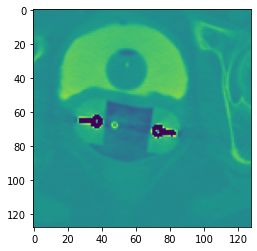

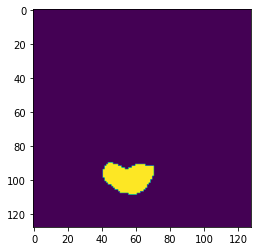

In [ ]:
def showImgAndMask(n):
    tImg = imgD[n].reshape((128, 128))
    tMask = imgY[n].reshape((128, 128))
    plt.imshow(tImg)
    plt.show()
    plt.imshow(tMask)
    plt.show()
showImgAndMask(26)

In [ ]:
def getAllYVals(noFrom, noTo):
    imgs = [ ]
    for no in range(noFrom, noTo):
        for z in range(0, readImgBound(no)["depth"]):
            imgs.append(getImgBound(no, z, True, 1, 4, 'dMask', 0, 1))
        print(no)
    imgs = np.array(imgs)
    # print(imgs.shape)
    imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], imgs.shape[2], 1))
    np.save("{}/0_range/{}-{}-2-y_128".format(dataPath, noFrom, noTo), imgs)
    return imgs